In [13]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from PIL import Image

In [3]:
model_1 = tf.keras.models.load_model(f"{os.getcwd()}/models/diabetic_multi-class_model_1")
model_2 = tf.keras.models.load_model(f"{os.getcwd()}/models/diabetic_multi-class_model_2")
model_3 = tf.keras.models.load_model(f"{os.getcwd()}/models/diabetic_multi-class_model_3")

In [4]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 1)       28        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 1)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16129)             0         
                                                                 
 dense (Dense)               (None, 128)               2064640   
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,065,313
Trainable params: 2,065,313
Non-trainable params: 0
______________________________________________

In [8]:
ds_1 = tf.keras.utils.image_dataset_from_directory(
    "retinopathy_dataset/gaussian_filtered_images/gaussian_filtered_images",
    seed=42,
    batch_size=50,
    image_size=(256,256),
    label_mode="categorical"
)

Found 3662 files belonging to 5 classes.


In [9]:
def normalized_imgs(imgs,labels):
    imgs = imgs/tf.reduce_max(imgs,axis=[0,1,2],keepdims=True)
    return tf.convert_to_tensor(imgs),tf.convert_to_tensor(labels)

nds_1 = ds_1.map(normalized_imgs,num_parallel_calls = tf.data.AUTOTUNE)


In [10]:
model_1.evaluate(nds_1)

74/74 [==============================] - 13s 42ms/step - loss: 0.0331 - accuracy: 0.9863


[0.03311161324381828, 0.9863462448120117]

In [11]:
model_2.evaluate(nds_1)
model_3.evaluate(nds_1)

74/74 [==============================] - 8s 87ms/step - loss: 7.7920 - accuracy: 0.4937


[7.792038440704346, 0.49371927976608276]

In [21]:
ds_2_path = "/tanlikesmath/diabetic-retinopathy-resized/versions/7/"
labels_df = pd.read_csv(f"{os.getcwd()}{ds_2_path}trainLabels_cropped.csv")

In [22]:
labels_df = labels_df[["image","level"]]
labels_df.loc[labels_df["level"]==4].count()

image    708
level    708
dtype: int64

In [41]:
def load_labelled_filepath(df,path):
    imgs_path = []
    for root,_,files in os.walk(f"{os.getcwd()}{path}"):
        for fname in files :
            if fname.lower().endswith(('.png','jpg','jpeg','bmp','gif')):
                full_path = os.path.join(root, fname)
                bname = os.path.splitext(fname)[0]
                imgs_path.append({
                    'filepath': full_path,
                    df.columns[0]: bname
                })

    return pd.DataFrame(imgs_path).merge(df,on=df.columns[0],how="left")

In [42]:
labelled_paths = load_labelled_filepath(labels_df,f"{ds_2_path}resized_train_cropped")
labelled_paths.head()

,filepath,image,level
0,C:\Users\thaim\Documents\Machine learning/tanl...,10003_left,0
1,C:\Users\thaim\Documents\Machine learning/tanl...,10003_right,0
2,C:\Users\thaim\Documents\Machine learning/tanl...,10007_left,0
3,C:\Users\thaim\Documents\Machine learning/tanl...,10007_right,0
4,C:\Users\thaim\Documents\Machine learning/tanl...,10009_left,0


In [49]:
labelled_paths.loc[labelled_paths["image"]=="15_left"]

,filepath,image,level
5284,C:\Users\thaim\Documents\Machine learning/tanl...,15_left,1


In [44]:
def load_img(path,size=None):
    img = Image.open(path).convert('RGB')
    if size :
        img = img.resize(size)
    return np.array(img)

def convert_to_dataset(df):
    loaded_imgs = df["filepath"].apply(lambda x: load_img(x,size=(254,254)))
    return loaded_imgs

In [45]:
loaded_imgs = convert_to_dataset(labelled_paths)

In [46]:
loaded_imgs.head()

0    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
1    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
2    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
3    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
4    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
Name: filepath, dtype: object

In [47]:
loaded_imgs.columns

AttributeError: 'Series' object has no attribute 'columns'

In [66]:
def chunk_list(lst, batch_size):
    """Yield successive batch-sized chunks from lst."""
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]
batch_size = 32
x_batches = []
imgs_list = loaded_imgs.tolist()

for batch in chunk_list(imgs_list, batch_size):
    # stack into (B, H, W, C), cast & normalize
    batch_arr = np.stack(batch).astype(np.float32) / 255.0
    x_batches.append(batch_arr)

MemoryError: Unable to allocate 25.3 GiB for an array with shape (35108, 254, 254, 3) and data type float32

In [70]:
x = np.concatenate(x_batches[:10], axis=0)

y = labelled_paths["level"].values[:320]
x.shape,y.shape

((320, 254, 254, 3), (320,))

In [56]:
type(y)

numpy.ndarray

In [63]:
# x is already a GPU tensor
max_cpu = tf.reduce_max(x[:10])        # this runs on CPU by default
max_gpu = tf.identity(max_cpu)         # copies it onto x.device (GPU)
x_normalized = x / max_gpu             # now both tensors are on GPU

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [137]:
import cv2
def preprocess_color_img(path,size=(254,254),sigma=1.0):
    """
    Read a color image (BGR → RGB), resize, apply LoG filter per channel, and normalize.
    Returns a float32 H×W×3 array with values in [0,1].
    """
    img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    blur = cv2.GaussianBlur(img, ksize=(0,0), sigmaX=sigma)
    log = cv2.Laplacian(blur, ddepth=cv2.CV_64F)  
    log = np.absolute(log)
    flat = log.reshape(-1, 3)
    mins = flat.min(axis=0)
    maxs = flat.max(axis=0)
    denom = np.where(maxs - mins > 0, (maxs - mins), 1)
    norm = (flat - mins) / denom
    norm = norm.reshape(log.shape)
    return norm.astype(np.float32)
N = len(balanced)

X = np.zeros((N,254,254,3), dtype=np.float32)
Y = balanced["level"].values

for i, fp in enumerate(balanced["filepath"]):
    X[i] = preprocess_color_img(fp, size=(254,254), sigma=1.0)

    

In [74]:
pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---- ----------------------------------- 4.2/39.5 MB 22.9 MB/s eta 0:00:02
   --------- ------------------------------ 9.2/39.5 MB 23.8 MB/s eta 0:00:02
   ------------- -------------------------- 13.6/39.5 MB 23.1 MB/s eta 0:00:02
   ------------------- -------------------- 18.9/39.5 MB 23.4 MB/s eta 0:00:01
   ------------------------ --------------- 24.6/39.5 MB 24.8 MB/s eta 0:00:01
   ------------------------------ --------- 30.1/39.5 MB 25.2 MB/s eta 0:00:01
   ------------------------------------ --- 36.2/39.5 MB 25.5 MB/s eta 0:00:01
   ---------------------------------------- 39.5/39.5 MB 25.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


2126


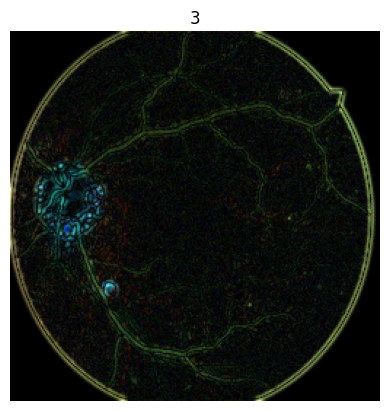

In [138]:
import matplotlib.pyplot as plt
# X[0] is your (H,W,3) float32 array in [0,1]
rand_n = np.where(Y == 3)[0][2]
print(rand_n)
plt.imshow(X[rand_n])
plt.title(Y[rand_n])
plt.axis('off')     # turn off the axes if you like
plt.show()

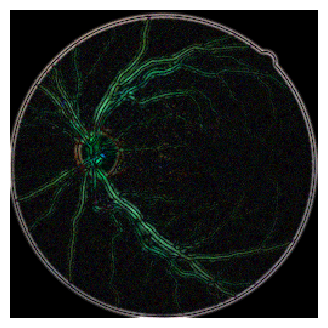

In [84]:
img = np.clip(X[0], 0, 1)

plt.figure(figsize=(4,4))
plt.imshow(img, interpolation='nearest')
plt.axis('off')
plt.show()

In [139]:
import os
import cv2
import numpy as np

def save_by_label(X, Y, out_dir='dataset_by_label', prefix='img'):
    """
    X: np.ndarray, shape (N,H,W) or (N,H,W,3), dtype uint8 [0–255] or float [0–1]
    Y: array-like of length N, labels (str or int)
    out_dir: root folder to create class subfolders in
    prefix: filename prefix, images will be named prefix_i.png
    """
    os.makedirs(out_dir, exist_ok=True)
    N = len(Y)
    
    for i, (img, label) in enumerate(zip(X, Y)):
        # 1) Prepare the label folder
        label_str = str(label)
        label_dir = os.path.join(out_dir, label_str)
        os.makedirs(label_dir, exist_ok=True)

        # 2) Convert image to uint8 BGR if needed
        #    handle float [0,1] → uint8 [0,255]
        if img.dtype in (np.float32, np.float64):
            img_uint8 = (img * 255).round().astype(np.uint8)
        else:
            img_uint8 = img

        #    if it’s RGB, convert to BGR for cv2
        if img_uint8.ndim == 3 and img_uint8.shape[2] == 3:
            to_save = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
        else:
            # grayscale or single‐channel
            to_save = img_uint8

        # 3) Choose a filename
        fname = f"{prefix}_{i:05d}.png"
        save_path = os.path.join(label_dir, fname)

        # 4) Write it out
        cv2.imwrite(save_path, to_save)

    print(f"Saved {N} images into {out_dir!r} with {len(set(Y))} class folders.")

# ─── USAGE ───
# X, Y already defined
save_by_label(X, Y, out_dir='gaussian_log-dog_filtered')


Saved 3540 images into 'gaussian_log-dog_filtered' with 5 class folders.


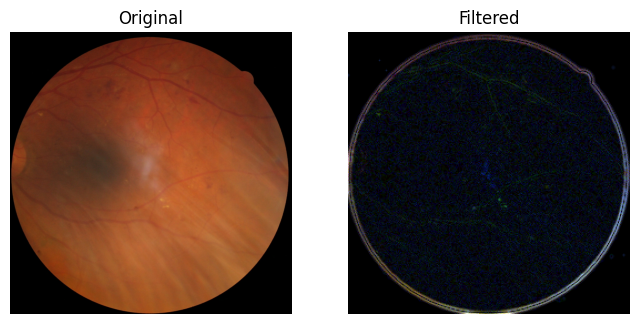

In [105]:
orig = cv2.cvtColor(cv2.imread(labelled_paths["filepath"].iloc[rand_n]), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(orig); plt.axis('off')
plt.subplot(1,2,2)
plt.title("Filtered")
plt.imshow(X[rand_n], vmin=0, vmax=1); plt.axis('off')
plt.show()

In [112]:
X[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [116]:
import cv2
import numpy as np

def load_rgb_img(path, size=(254,254)):
    """
    Read a color image in RGB uint8 [0,255], resize, and return H×W×3.
    """
    # 1) load BGR uint8 [0–255]
    img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    # 2) convert to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # 3) resize
    img_rgb = cv2.resize(img_rgb, size, interpolation=cv2.INTER_AREA)
    return img_rgb  # dtype=uint8, values in 0–255

# ─── Build a small batch of N=500 ───
N         = 500
filepaths = labelled_paths["filepath"].iloc[:N]
labels    = labelled_paths["level"].values[:N]

# pre-allocate X as uint8 to hold raw RGB
X = np.zeros((N, 254, 254, 3), dtype=np.uint8)
Y = labels

for i, fp in enumerate(filepaths):
    X[i] = load_rgb_img(fp, size=(254,254))

# Now X[i] is just the normal RGB image (0–255), no filtering or scaling.


In [116]:
import cv2
import numpy as np

def load_rgb_img(path, size=(254,254)):
    """
    Read a color image in RGB uint8 [0,255], resize, and return H×W×3.
    """
    # 1) load BGR uint8 [0–255]
    img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    # 2) convert to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # 3) resize
    img_rgb = cv2.resize(img_rgb, size, interpolation=cv2.INTER_AREA)
    return img_rgb  # dtype=uint8, values in 0–255

# ─── Build a small batch of N=500 ───
N         = 500
filepaths = labelled_paths["filepath"].iloc[:N]
labels    = labelled_paths["level"].values[:N]

# pre-allocate X as uint8 to hold raw RGB
X = np.zeros((N, 254, 254, 3), dtype=np.uint8)
Y = labels

for i, fp in enumerate(filepaths):
    X[i] = load_rgb_img(fp, size=(254,254))

# Now X[i] is just the normal RGB image (0–255), no filtering or scaling.


In [118]:
tf.reduce_max(X).numpy()

255

In [127]:
min_size = labelled_paths["level"].value_counts().min()

In [127]:
min_size = labelled_paths["level"].value_counts().min()

In [128]:
balanced = (
    labelled_paths
    .groupby('level', group_keys=False)            # don’t add extra index
    .apply(lambda g: g.sample(n=min_size, random_state=42))
    .reset_index(drop=True)
)


C:\Users\thaim\AppData\Local\Temp\ipykernel_29208\1326503138.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min_size, random_state=42))


In [131]:
balanced["level"].value_counts()

level
0    708
1    708
2    708
3    708
4    708
Name: count, dtype: int64

In [134]:
len(balanced)

3540

In [135]:
X 

74

In [143]:
def preprocess_green(path, size=(254,254), sigma=1.0):
    """
    1) Load the green channel of the BGR image.
    2) Resize.
    3) Gaussian blur.
    4) Laplacian (absolute value) → vessel/high-pass response.
    5) Min-max normalize to [0,1].
    Returns: float32 H×W array.
    """
    # 1) green channel
    img = cv2.imread(path, cv2.IMREAD_COLOR)[:, :, 1]
    # 2) resize
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    # 3) blur
    blur = cv2.GaussianBlur(img, ksize=(0,0), sigmaX=sigma)
    # 4) Laplacian + absolute
    log  = cv2.Laplacian(blur, ddepth=cv2.CV_64F)
    log  = np.absolute(log)
    # 5) normalize
    mn, mx = log.min(), log.max()
    if mx > mn:
        log = (log - mn) / (mx - mn)
    else:
        log = log * 0.0
    return log.astype(np.float32)

# ─── Build & save ───


X_green = np.zeros((N,254,254), dtype=np.float32)

for i, fp in enumerate(balanced["filepath"]):
    X_green[i] = preprocess_green(fp, size=(254,254), sigma=1.0)


save_by_label(X_green, Y, out_dir='gaussian_log-dog_filtered_green')


Saved 3540 images into 'gaussian_log-dog_filtered_green' with 5 class folders.
